In [162]:
import pandas as pd 
import numpy as np
import joblib
import os
import sklearn
import xgboost
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold


In [163]:
print("Python:", os.sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("joblib:", joblib.__version__)

Python: 3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:14) [MSC v.1929 64 bit (AMD64)]
pandas: 2.2.3
numpy: 2.2.5
scikit-learn: 1.6.1
xgboost: 3.0.1
joblib: 1.5.1


## Environment dan Versi Library

Notebook ini dijalankan menggunakan **Python 3.13.2 (Anaconda)** dengan versi library sebagai berikut:

| Library       | Version  |
|---------------|----------|
| pandas        | 2.2.3    |
| numpy         | 2.2.5    |
| scikit-learn  | 1.6.1    |
| xgboost       | 3.0.1    |
| joblib        | 1.5.1    |

Untuk mereplikasi environment ini, jalankan:
```bash
pip install -r requirements.txt


In [164]:
df=pd.read_csv('dataset/recruitment_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1500 non-null   int64  
 1   Gender               1500 non-null   int64  
 2   EducationLevel       1500 non-null   int64  
 3   ExperienceYears      1500 non-null   int64  
 4   PreviousCompanies    1500 non-null   int64  
 5   DistanceFromCompany  1500 non-null   float64
 6   InterviewScore       1500 non-null   int64  
 7   SkillScore           1500 non-null   int64  
 8   PersonalityScore     1500 non-null   int64  
 9   RecruitmentStrategy  1500 non-null   int64  
 10  HiringDecision       1500 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 129.0 KB


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1500 non-null   int64  
 1   Gender               1500 non-null   int64  
 2   EducationLevel       1500 non-null   int64  
 3   ExperienceYears      1500 non-null   int64  
 4   PreviousCompanies    1500 non-null   int64  
 5   DistanceFromCompany  1500 non-null   float64
 6   InterviewScore       1500 non-null   int64  
 7   SkillScore           1500 non-null   int64  
 8   PersonalityScore     1500 non-null   int64  
 9   RecruitmentStrategy  1500 non-null   int64  
 10  HiringDecision       1500 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 129.0 KB


## Pipeline Data Preprocessing

In [166]:
# =====================
# 1. Load data from CSV
# =====================
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

X_train = train_df.drop(["HiringDecision", "Age", "DistanceFromCompany", "Gender",'PreviousCompanies'], axis=1)
y_train = train_df["HiringDecision"]

X_test = test_df.drop(["HiringDecision", "Age", "DistanceFromCompany", "Gender",'PreviousCompanies'], axis=1)
y_test = test_df["HiringDecision"]



In [167]:

# =====================
# 3. Preprocessing setup
# =====================

class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # 1. Drop duplicates
        X = X.drop_duplicates()
        
        # 2. Missing value handling
        for col in X.select_dtypes(include=["float", "int"]).columns:
            X[col] = X[col].fillna(X[col].median())   # numeric → median
        for col in X.select_dtypes(include=["object"]).columns:
            X[col] = X[col].fillna(X[col].mode()[0]) # categorical → modus
        
        # 3. Outlier handling (IQR method pada numerical)
        for col in X.select_dtypes(include=["float", "int"]).columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
            X[col] = np.where(X[col] < lower, lower,
                              np.where(X[col] > upper, upper, X[col]))
        
        return X
    
# b. ExperienceYears → binning (junior/mid/senior)
def bin_experience(x):
    bins = np.array(x).astype(int).ravel()
    labels = []
    for v in bins:
        if v <=2:
            labels.append("Junior")
        elif v <=5:
            labels.append("Mid")
        else:
            labels.append("Senior")
    return np.array(labels).reshape(-1,1)


# a. EducationLevel → OH encode
edu_pipeline = Pipeline([
    ("onehot", OneHotEncoder(drop="first"))  # one-hot encode EducationLevel
])

exp_pipeline = Pipeline([
    ("binning", FunctionTransformer(bin_experience, validate=False,feature_names_out="one-to-one")),
    ("onehot", OneHotEncoder(drop="first"))  # one-hot encode hasil binning
])

# c. RecruitmentStrategy → one-hot encode
recruitment_pipeline = Pipeline([
    ("onehot", OneHotEncoder(drop="first"))
])

# d. Numerical features → scaling
num_features = ["InterviewScore", "SkillScore", "PersonalityScore"]
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# =====================
# 4. ColumnTransformer
# =====================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_features),
        ("recruitment", recruitment_pipeline, ["RecruitmentStrategy"]),
        ("education", edu_pipeline, ["EducationLevel"]),        
        ("experience", exp_pipeline, ["ExperienceYears"])
    ],
    remainder="drop"
)


# Pipeline gabungan: cleaning + preprocessing


preprocessor.fit(X_train)
# # Simpan pipeline preprocessing
joblib.dump(preprocessor, "preprocesor.pkl")
print("Pipeline preprocessing berhasil disimpan.")



full_pipeline = Pipeline([
    ("cleaning", DataCleaner()),   # tahap cleaning
    ("preprocessing", preprocessor) # tahap preprocessing (OH, scaling, dsb.)
])
# Transform data
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed  = full_pipeline.transform(X_test)

print("Train shape:", X_train_transformed.shape)
print("Test shape :", X_test_transformed.shape)





Pipeline preprocessing berhasil disimpan.
Train shape: (1200, 10)
Test shape : (300, 10)


## Modeling

In [168]:
# =========================================
# Fungsi Evaluasi Model (Train vs Test)
# =========================================
def evaluate_train_test(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Prediksi Train
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]

    # Prediksi Test
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Hasil Train
    train_results = {
        "Accuracy": accuracy_score(y_train, y_train_pred),
        "Precision": precision_score(y_train, y_train_pred),
        "Recall": recall_score(y_train, y_train_pred),
        "F1-Score": f1_score(y_train, y_train_pred),
        "ROC-AUC": roc_auc_score(y_train, y_train_prob)
    }

    # Hasil Test
    test_results = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1-Score": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_prob)
    }

    # Gap (%)
    gap_results = {m: 100 * (train_results[m] - test_results[m]) for m in train_results}

    # Buat DataFrame untuk tampilan tabel
    df_results = pd.DataFrame([
        {"Model": model_name, "Dataset": "Train", **train_results},
        {"Model": model_name, "Dataset": "Test", **test_results},
        {"Model": model_name, "Dataset": "Gap (%)", **gap_results},
    ])

    return df_results

## XGBoost memberikan hasil yang lebih baik dan stabil

In [169]:
# =========================================
# 3. XGBoost
# =========================================
xgb = XGBClassifier(random_state=42, eval_metric='logloss')


xgb_param_dist = {
    'n_estimators': np.arange(100, 501, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [2, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=30,
    cv=cv,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
xgb_random.fit(X_train_transformed, y_train)

print("="*40)
print("===== Hasil Hyperparameter Tuning  RandomizedSearchCV (XGBoost) =====")
print("Best Hyperparameter:", xgb_random.best_params_)
print("Best F1 Score :", xgb_random.best_score_)

best_xgb = xgb_random.best_estimator_
df_xgb_eval = evaluate_train_test(best_xgb, X_train_transformed, y_train,
                                  X_test_transformed, y_test,
                                  model_name="XGBoost")
display(df_xgb_eval)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
===== Hasil Hyperparameter Tuning  RandomizedSearchCV (XGBoost) =====
Best Hyperparameter: {'subsample': 0.6, 'n_estimators': np.int64(500), 'max_depth': 2, 'learning_rate': np.float64(0.3), 'gamma': 5, 'colsample_bytree': 0.8}
Best F1 Score : 0.8815239920074692


,Model,Dataset,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,XGBoost,Train,0.958333,0.968023,0.895161,0.930168,0.947551
1,XGBoost,Test,0.946667,0.963855,0.860215,0.909091,0.935406
2,XGBoost,Gap (%),1.166667,0.416783,3.494624,2.107669,1.214547


In [170]:
model_filename = 'best_xgboost_model.pkl'
joblib.dump(best_xgb, model_filename)
print(f"\nModel terbaik berhasil disimpan di file '{model_filename}'")


Model terbaik berhasil disimpan di file 'best_xgboost_model.pkl'


In [171]:
joblib.dump(best_xgb, 'best_xgboost_model.joblib')
print(f"\nModel terbaik berhasil disimpan di file ")


Model terbaik berhasil disimpan di file 


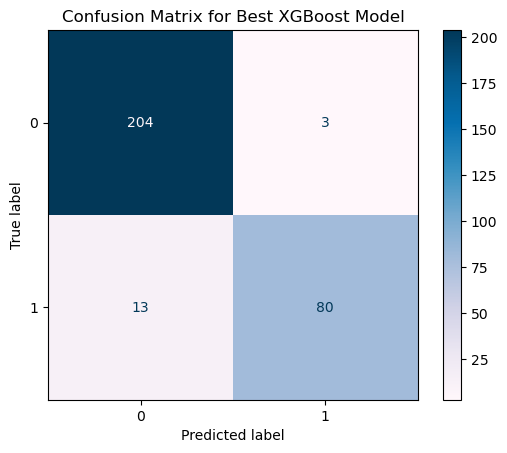

Confusion Matrix:
[[204   3]
 [ 13  80]]


In [172]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Tampilkan visualisasi confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgboost_model.classes_)
disp.plot(cmap='PuBu')

# Tambahkan judul dan tampilkan plot
plt.title('Confusion Matrix for Best XGBoost Model')
plt.show()

# Jika ingin melihat angkanya saja
print("Confusion Matrix:")
print(cm)

In [173]:
def evaluate_models(models, X_train, y_train, X_test, y_test, save_csv=True):
    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)

        # === TRAIN ===
        y_train_pred = model.predict(X_train)
        y_train_prob = model.predict_proba(X_train)[:, 1]
        report_train = classification_report(y_train, y_train_pred, output_dict=True)
        roc_auc_train = roc_auc_score(y_train, y_train_prob)

        # === TEST ===
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)[:, 1]
        report_test = classification_report(y_test, y_test_pred, output_dict=True)
        roc_auc_test = roc_auc_score(y_test, y_test_prob)

        # === Gabungkan semua metrik ===
        metrics = {
            "Model":               [name, name],  # supaya ada di Train & Test
            "Precision ": [round(report_train["1"]["precision"], 4), round(report_test["1"]["precision"], 4)],
            # "Recall (class 1)":    [round(report_train["1"]["recall"], 3),    round(report_test["1"]["recall"], 3)],
            "F1-score ":  [round(report_train["1"]["f1-score"], 4),  round(report_test["1"]["f1-score"], 4)],
            # "Accuracy":            [round(report_train["accuracy"], 3),       round(report_test["accuracy"], 3)],
            "ROC AUC":             [round(roc_auc_train, 3),                  round(roc_auc_test, 5)]
        }

        df_metrics = pd.DataFrame(metrics, index=["Train", "Test"])

        # === Hitung Gap (%) hanya untuk kolom numerik ===
        numeric_cols = df_metrics.select_dtypes(include="number").columns
        gap_values = ((df_metrics.loc["Train", numeric_cols] - df_metrics.loc["Test", numeric_cols])
                      / df_metrics.loc["Train", numeric_cols] * 100).round(2)

        # tambahkan model di gap row
        gap_row = pd.Series({col: gap_values.get(col, None) for col in df_metrics.columns} | {"Model": name},name="Gap (%)")

        # gap_row = pd.Series({col: gap_values.get(col, None) for col in df_metrics.columns}, name="Gap (%)")
        gap_row["Model"] = name

        # gabungkan
        df_metrics = pd.concat([df_metrics, gap_row.to_frame().T])

        # Reset index agar ada kolom Dataset
        df_metrics = df_metrics.reset_index().rename(columns={"index": "Dataset"})

          # Hanya ambil baris Test & Gap
        df_metrics = df_metrics[df_metrics["Dataset"].isin(["Test", "Gap (%)"])]

        # Urutkan kolom: Model dulu
        cols = ["Model", "Dataset"] + [c for c in df_metrics.columns if c not in ["Model", "Dataset"]]
        df_metrics = df_metrics[cols]

        results.append(df_metrics)

    # Gabungkan semua hasil
    final_results = pd.concat(results, ignore_index=True)

    # === Ranking berdasarkan ROC AUC Test ===
    ranking = (
        final_results[final_results["Dataset"] == "Test"]
        .sort_values(by="ROC AUC", ascending=False)[["Model", "ROC AUC"]]
        .reset_index(drop=True)
    )
    ranking.index = ranking.index + 1  # biar mulai dari 1

    return final_results, ranking


In [174]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42,class_weight="balanced"),
    "XGBoost (Tuned)": best_xgb
}

# ==== Panggil fungsi ====
final_results_xgb_logreg, ranking = evaluate_models(models, X_train_transformed, y_train, X_test_transformed, y_test)

print("\n📊 Hasil Evaluasi Model:")
display(final_results_xgb_logreg)

print("\n🏆 Ranking Model berdasarkan ROC AUC (Test):")
display(ranking)
# # # Nama folder yang diinginkan
# folder_path = 'file_exp'

# # Cek apakah folder sudah ada, jika tidak, buat folder tersebut
# if not os.path.exists(folder_path):
#     os.path.makedirs(folder_path)
#     print(f"Folder '{folder_path}' berhasil dibuat.")

# # Buat path lengkap untuk file Excel
# file_path = os.path.join(folder_path, 'final_results_xgb_logreg.xlsx')

# # Asumsikan 'hasil_evaluasi' adalah DataFrame
# final_results_xgb_logreg.to_excel(file_path, index=True)

# print(f"Hasil evaluasi telah berhasil disimpan ke: {file_path}")


📊 Hasil Evaluasi Model:


,Model,Dataset,Precision,F1-score,ROC AUC
0,Logistic Regression,Test,0.7642,0.8141,0.92198
1,Logistic Regression,Gap (%),-1.044559,0.561866,0.541532
2,XGBoost (Tuned),Test,0.9639,0.9091,0.93541
3,XGBoost (Tuned),Gap (%),0.423554,2.268329,1.328059



🏆 Ranking Model berdasarkan ROC AUC (Test):


,Model,ROC AUC
1,XGBoost (Tuned),0.93541
2,Logistic Regression,0.92198
